In [1]:
import logging

import numpy as np
import torch 

import aeroCNV as aero 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white')

# Autoreload aeroCNV module when it is modified
%load_ext autoreload
%autoreload 2

In [2]:
aero.initialize_logger(level=logging.INFO)

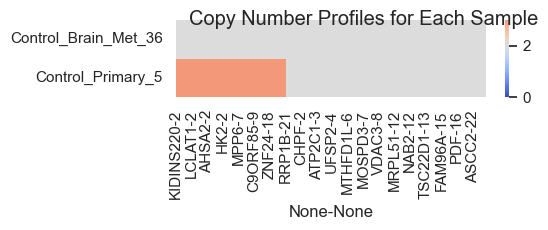

The number of genes with each copy number in each sample are: 
                         2    3
Control_Brain_Met_36  1391    0
Control_Primary_5      896  495
There are 3416 diploid cells (Control_Primary_5) and 2052 normal cells (Control_Brain_Met_36).


In [3]:
cnvs, expression = aero.simulate_data.describe_profiles_A()

In [4]:
diploid_ref, expression, labels = aero.simulate_data.one_clone_piecewise_from_real_data(n_tumour_cells=1000, n_normal_cells=1000, n_reference_cells=1000, alteration_widths=[50], total_genome_length=1000)
# We will give genes dummy names so that they are sorted correctly on the chromosome
n_genes_on_chr_1 = expression.shape[1]//3
n_genes_on_chr_2 = expression.shape[1] - n_genes_on_chr_1

genemap = aero.utils.load_genemap()[0]
genes_on_chr_1 = list(genemap[1])[:n_genes_on_chr_1]
genes_on_chr_2 = list(genemap[2])[n_genes_on_chr_1:n_genes_on_chr_1+n_genes_on_chr_2]

sorted_genes_on_chr_1 = aero.utils.order_genes(genes_on_chr_1)[0]['Gene']
sorted_genes_on_chr_2 = aero.utils.order_genes(genes_on_chr_2)[0]['Gene']

genes_in_order = list(sorted_genes_on_chr_1) + list(sorted_genes_on_chr_2)
expression.columns = genes_in_order
diploid_ref.columns = genes_in_order
labels.columns = genes_in_order

sorted_genes = aero.utils.order_genes(expression.columns)[0]['Gene']
assert (sorted_genes.values == expression.columns).all(), 'Genes are not in the correct chromosomal order.'

In total we have 950 normal genes and 50 altered genes
Sampled 1000 tumour cells and 1000 normal cells from the dataset, giving a total of 2000 cells.


2024-06-20 13:39:44 - aeroCNV - INFO - Sorted 315 genes according to their chromosomal location
2024-06-20 13:39:44 - aeroCNV - INFO - Sorted 631 genes according to their chromosomal location
2024-06-20 13:39:44 - aeroCNV - INFO - Sorted 946 genes according to their chromosomal location


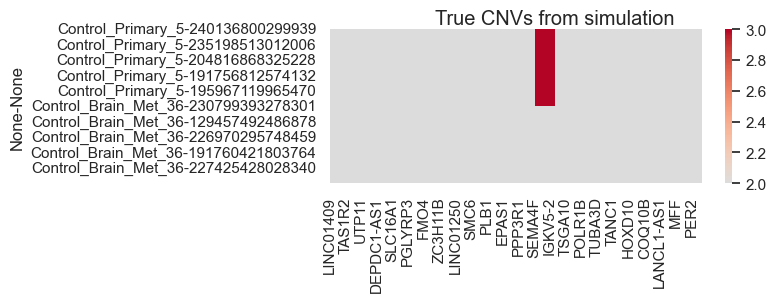

In [5]:
plt.figure(figsize=(6,2))
sns.heatmap(labels, cmap='coolwarm', center=2)
plt.suptitle('True CNVs from simulation')
plt.show()
plt.close()

# Cell Metadata

aeroCNV takes cell metadata as input. This metadata is a DataFrame with the following columns:
- `Celltype`: The cell type of the cell. This is used to model cell-type specific gene-dosage effects.
- `Clone`: The clone that the cell belongs to. This is used to model clone-specific transitions.
- `Normalization`: The normalization factor for the cell. This is used to model library size effects.

If the celltype is not known, we can set all cells to the same celltype. If the clone is not known, we can set all cells to the same clone. 
Ideally, the normalization factor for each cell is the average gene expression for genes that are not expected to be altered. However, if this 
is not known, we can use any other library size normalization factor, e.g. the mean gene expression for each cell.

In [6]:
cell_metadata = pd.DataFrame(index=expression.index)
cell_metadata['Celltype'] = 'Tumour'
cell_metadata['Clone'] = 'Clone1'
cell_metadata['Normalization'] = expression.mean(axis=1)

In [7]:
cell_metadata.head()

Celltype   Clone  Normalization
Control_Primary_5 240136800299939   Tumour  Clone1       1.918605
                  125197046168821   Tumour  Clone1       0.908034
                  200416659892059   Tumour  Clone1       1.423890
                  134936690056419   Tumour  Clone1       1.015856
                  196174333730083   Tumour  Clone1       0.749471

# Diploid Mean

We use the mean gene expression of the diploid reference cells to estimate the diploid mean. This is the mean gene expression of the diploid reference cells for each celltype.
In this simulation, we have one celltype so we will use the mean of all the diploid reference cells.

If you are modeling different cell types with different expected diploid gene expression levels, use the cells corresponding to that cell type to estimate the diploid mean for that cell type.


#### Extremely important:
The diploid reference must be normalized using the same method as use to compute the normalization factor in the cell metadata. 

In [8]:
diploid_ref = diploid_ref.loc[:, sorted_genes]
# Normalize the diploid reference using the same normalization method as the cell metadata. In this case, we used the average library size for each cell as the normalization factor, so we will divide the diploid reference by the average library size for each cell.
diploid_ref = diploid_ref/diploid_ref.mean(axis=1).values[:, None]
diploid_mean = pd.DataFrame(columns=cell_metadata['Celltype'].unique(), index=expression.columns)
for celltype in cell_metadata['Celltype'].unique():
    diploid_mean.loc[:, celltype] = diploid_ref.mean(axis=0)
print(diploid_mean.head())

             Tumour
LINC01409  0.179336
HES4       0.306156
ISG15      0.183808
RNF223      2.19408
TNFRSF4    0.027686


In [9]:
def estimate_alphas(expression, diploid_mean, modifiers, labels):
    expression = expression.copy().astype(float)
    expected_expression = modifiers*diploid_mean
    expected_expression = pd.DataFrame(expected_expression, index=expression.index, columns=expression.columns).astype(float)
    
    # Remove reset genes from both 
    keep_genes = expression.columns[~expression.columns.str.contains('RESET')]
    expression  = expression.loc[:, keep_genes]
    expected_expression = expected_expression.loc[:, keep_genes]
    labels = labels.loc[:, keep_genes]
    
    print(f'Expression shape: {expression.shape}')
    print(f'Expected expression shape: {expected_expression.shape}')
    print(f'Labels shape: {labels.shape}')
    
    # we are interested in genes where the copy number is 3; check which columns of labels have a value of 3
    columns = labels.columns[labels.iloc[0] == 3]
    alphas = []
    for col in columns:
        # Select cells where the CNV is 3
        cells = labels.index[labels.loc[:, col] == 3]
        
        log_expression = np.log(expression.loc[cells, col])
        log_expected_expression = np.log(expected_expression.loc[cells, col])
        keep_vals = np.where(np.isfinite(log_expression) & np.isfinite(log_expected_expression))[0]
        log_expression = log_expression.iloc[keep_vals]
        log_expected_expression = log_expected_expression.iloc[keep_vals]
        log_cnv = np.log(3/2)
        alpha = (log_expression - log_expected_expression)/log_cnv
        alphas.append(alpha.mean())
            
    plt.figure(figsize=(6,2))
    sns.histplot(alphas, kde=True)
    plt.show()
    plt.close()
    
    return expected_expression

Expression shape: (2000, 946)
Expected expression shape: (2000, 946)
Labels shape: (2000, 946)


/Users/sitarapersad/Documents/research/cnvHMM/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


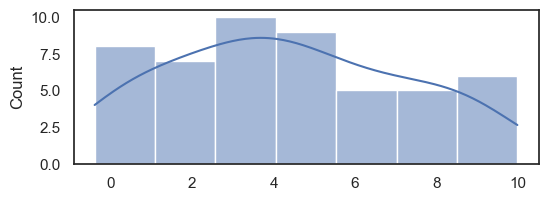

In [10]:
E_est = estimate_alphas(expression, diploid_mean['Tumour'].values.reshape(1,-1), cell_metadata['Normalization'].values.reshape(-1,1), labels)

# Clone-Specific Transition Priors

We can also encode priors on expected copy number transitions for each clone. This is encoded in the pair (epsilon, offset) for each gene. The default transition matrix is a matrix offset 0 and with 1-epsilon on the diagonal and the remainder on the off-diagonal, encoding the prior that copy number changes are unlikely. If the offset is non-zero, then majority of the probability is now placed on the off-diagonal, encoding the prior that copy number changes are likely.

A higher epsilon value means that copy number changes not along the offset are more likely, whereas a lower epsilon value prioritized copy number changes along the offset.

For example, we may know from bulk WES that there is likely a copy number amplification between Gene 5 and Gene 6; then we can encode this prior either as:
(1) An increased probability of an off diagonal transition between Gene 5 and Gene 6 (high epsilon value)
(2) A prior on the expected off-diagonal transition between Gene 5 and Gene 6 (amplified offset value)

epsilon = 0.1, offset = 1 encodes a prior that copy number changes are likely and are likely to be amplified.
```
    S1   S2    S3
S1  0.05  0.9   0.05
S2  0.05  0.05   0.9
S3  0.05  0.05   0.9
```

If no prior is known, we can specify None for the clone-specific transition priors, and default values of epsilon=0.1, offset=0 will be used.

In [11]:
clone_transition_priors = {}

for clone in cell_metadata['Clone'].unique():
    clone_transition_priors[clone] = aero.utils.generate_default_transitions(expression.columns, epsilon=0.1, offset=0)
clone_transition_priors = pd.concat(clone_transition_priors, axis=1)
print(clone_transition_priors.head())

           Clone1       
          epsilon offset
LINC01409     0.1      0
HES4          0.1      0
ISG15         0.1      0
RNF223        0.1      0
TNFRSF4       0.1      0


# aeroCNV 
Run aeroCNV to automatically infer CNVs from expression data.

<Axes: ylabel='None-None'>

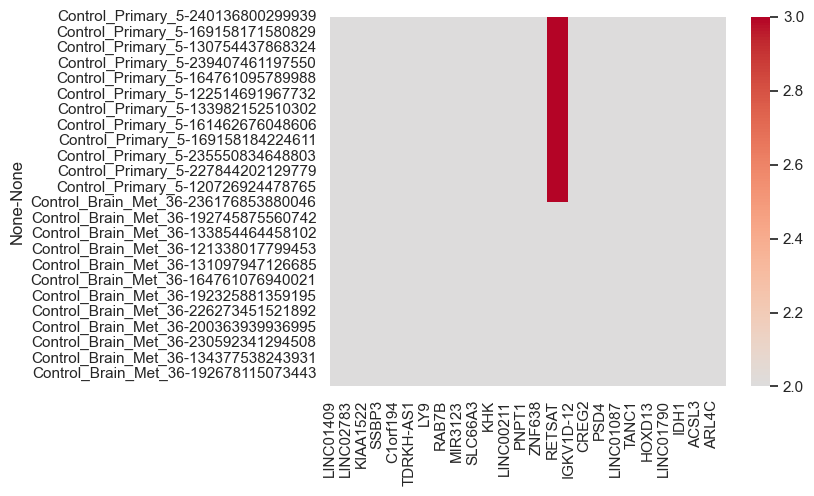

In [16]:
sns.heatmap(labels, cmap='coolwarm', center=2)

2024-06-20 13:42:46 - aeroCNV - INFO - Removed 48 genes due to low expression.
2024-06-20 13:42:46 - aeroCNV - INFO - Sorted 898 genes according to their chromosomal location
2024-06-20 13:42:47 - aeroCNV - INFO - Fitting to data.
2024-06-20 13:42:57 - aeroCNV - INFO - Iteration 5 after 9.88 seconds
2024-06-20 13:43:07 - aeroCNV - INFO - Iteration 10 after 20.38 seconds
2024-06-20 13:43:17 - aeroCNV - INFO - Iteration 15 after 30.26 seconds
2024-06-20 13:43:22 - aeroCNV - WARNING - Model has not converged after 16 iterations
2024-06-20 13:43:22 - aeroCNV - WARNING - Terminating training due to max_iters reached at 15 after 35.39 seconds


AUC: 0.6778604491320268


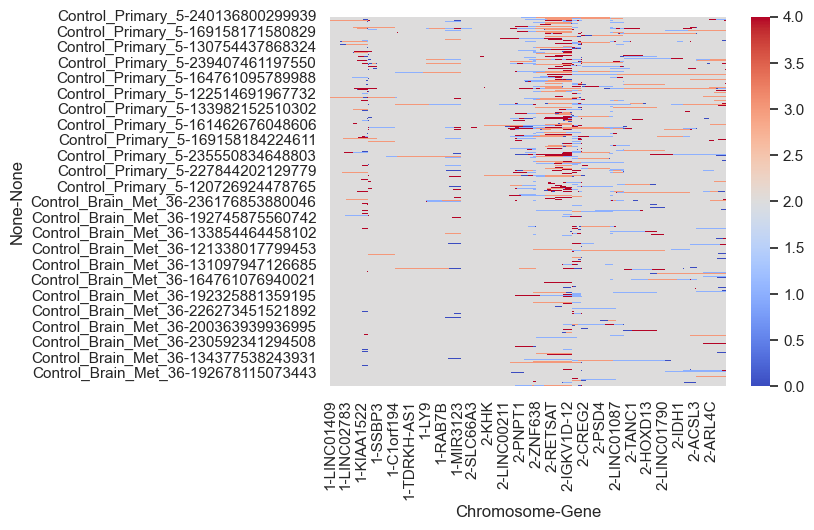

In [17]:
from importlib import reload
import aeroCNV as aero
reload(aero)
reload(aero)

model = aero.cnvHMM(observations=expression,
                    observation_metadata=cell_metadata,
                    n_states=5,
                    diploid_means=diploid_mean,
                    clone_transitions=clone_transition_priors,
                    gexp_percentile_threshold=5,
                    )

model.verify()
model.fit(freeze_emissions=True, max_iters=15)
sns.heatmap(model.predict(), cmap='coolwarm', center=2)

paths = model.predict()
labels = labels[paths.columns.get_level_values('Gene')]
altered = paths != 2
altered_true = labels != 2

# Compute auc score for labels
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(altered_true.values.flatten(), altered.values.flatten())
print(f'AUC: {auc}')


2024-06-20 13:43:26 - aeroCNV - INFO - Removed 48 genes due to low expression.
2024-06-20 13:43:26 - aeroCNV - INFO - Sorted 898 genes according to their chromosomal location
2024-06-20 13:43:26 - aeroCNV - INFO - Fitting to data.
2024-06-20 13:43:46 - aeroCNV - INFO - Iteration 5 after 19.69 seconds
2024-06-20 13:44:09 - aeroCNV - INFO - Iteration 10 after 43.20 seconds
2024-06-20 13:44:32 - aeroCNV - INFO - Iteration 15 after 65.99 seconds
2024-06-20 13:44:41 - aeroCNV - WARNING - Model has not converged after 16 iterations
2024-06-20 13:44:41 - aeroCNV - WARNING - Terminating training due to max_iters reached at 15 after 75.23 seconds


AUC: 0.7061998102259042


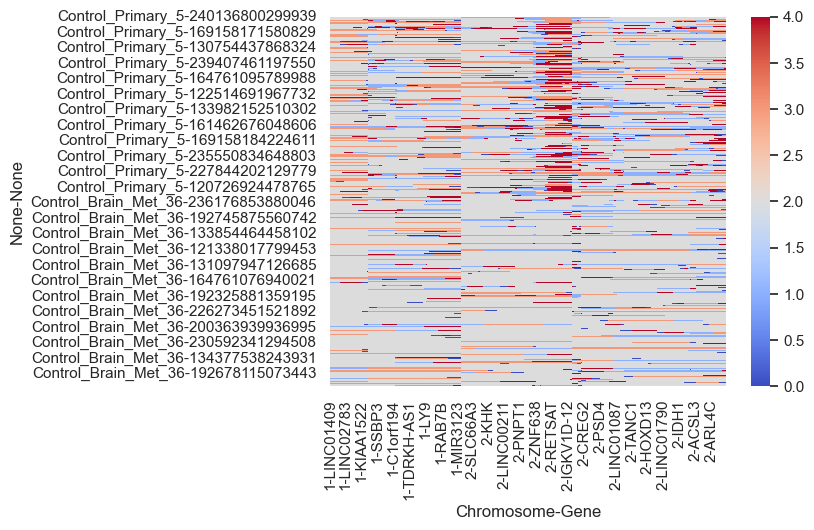

In [18]:
from importlib import reload
import aeroCNV as aero
reload(aero)
reload(aero)

model = aero.cnvHMM(observations=expression,
                    observation_metadata=cell_metadata,
                    n_states=5,
                    diploid_means=diploid_mean,
                    clone_transitions=clone_transition_priors,
                    gexp_percentile_threshold=5,
                    )

model.verify()
model.fit(freeze_emissions=False, max_iters=15)
sns.heatmap(model.predict(), cmap='coolwarm', center=2)

paths = model.predict()
labels = labels[paths.columns.get_level_values('Gene')]
altered = paths != 2
altered_true = labels != 2

# Compute auc score for labels
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(altered_true.values.flatten(), altered.values.flatten())
print(f'AUC: {auc}')


In [43]:
import picasso

In [24]:
ternary_paths = picasso.utils.encode_cnvs_as_ternary(paths-2)

<Axes: ylabel='None-None'>

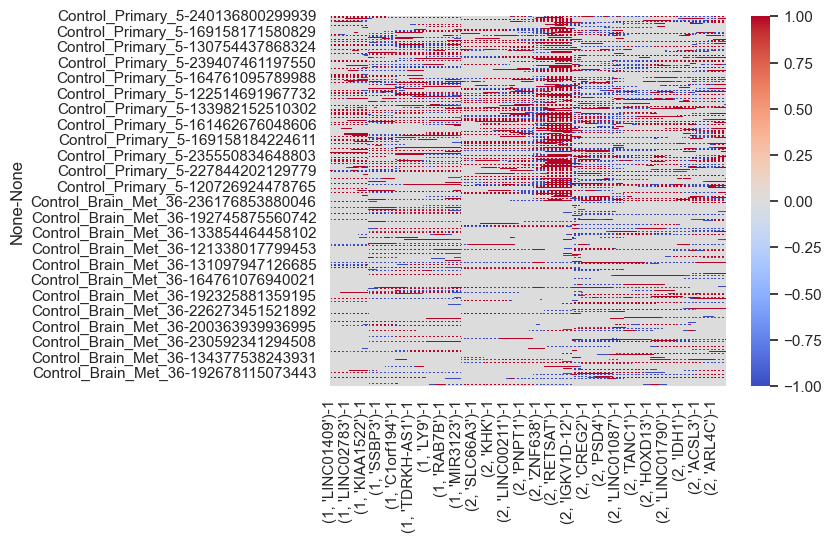

In [25]:
sns.heatmap(ternary_paths, cmap='coolwarm', center=0)

In [44]:
import picasso
# Use picasso to build tree on CNV paths
tree_model = picasso.Picasso(paths, max_depth=1)

In [45]:
tree_model.fit()

Tree Depth 1: 1 clone(s), 0 terminal clone(s). Force Split: False
100%|██████████| 1/1 [00:08<00:00,  8.39s/it]
Maximum depth of 1 reached.
PICASSO algorithm finished in 8.39 seconds.


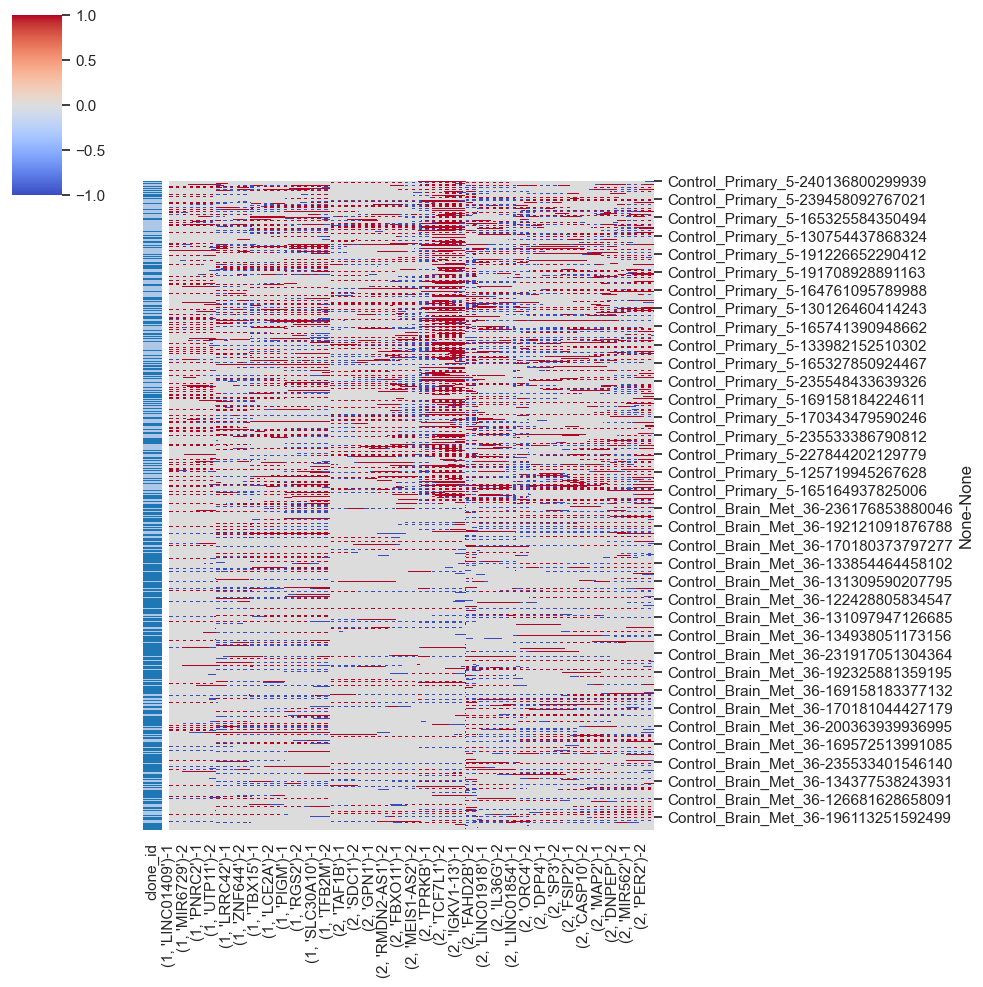

In [46]:

# Colour cells on heatmap by clone assignment
clone_assignments = tree_model.get_clone_assignments()
assignment_cm = sns.color_palette('tab20', n_colors=len(clone_assignments['clone_id'].unique()))
assignment_cm = dict(zip(clone_assignments['clone_id'].unique(), assignment_cm))
clone_assignment_colours = clone_assignments['clone_id'].map(assignment_cm)

sns.clustermap(ternary_paths, cmap='coolwarm', center=0, row_colors=clone_assignment_colours, row_cluster=False, col_cluster=False)

In [47]:
## Let's look at how inferCNV compares on this dataset
import infercnvpy





/Users/sitarapersad/Documents/research/cnvHMM/.venv/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/Users/sitarapersad/Documents/research/cnvHMM/.venv/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/Users/sitarapersad/Documents/research/cnvHMM/.venv/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/Users/sitarapersad/Documents/research/cnvHMM/.venv/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'
  """ Optimise the given partitions simultaneously.


AttributeError: module 'infercnvpy' has no attribute 'run_infercnv'